# Construccion de Grafo

Tutorial de uso del paquete de embeddings de grafos

El paquete tiene 3 modulos propios: funciones, visitconstructor y tuning,

Se necesitan 3 modulos "no tradicionales": Backboning, OpenNE y  EvalNe


In [8]:
import importlib
import pickle

#import model
import networkx as nx
import numpy as np 
import pandas as pd

from h3 import h3

from tqdm import tqdm
import matplotlib.pyplot as plt

import funciones as fn
import visitconstructor


get_visits: funcion que entrega los usuarios, propiedades, y visitas de de un cierto intervalo de tiempo, tambien saca outliers  y oficinas/empresas. Esta es la funcion que se substituye por lo que quieras.

In [2]:
def get_visits(desde_users="2019-02-01",hasta_users="2019-06-01",desde_visits="2019-02-01",hasta_visits="2019-06-01"):
    """Carga de Usuarios y Propiedades de SQL"""
    SQL = visitconstructor.FromSQL()
    propquery = ('SELECT id, id_modalidad,id_tipo_propiedad, ubicacion_latitud, ubicacion_longitud, valor_uf '
                'FROM propiedad '
                'JOIN propiedad_valor_uf AS uf ON uf.id_propiedad=id '
                'WHERE id_region = 13 '
                'AND id_tipo_propiedad !=3 '
                'AND ubicacion_latitud BETWEEN -35 and -32 '
                'AND ubicacion_longitud BETWEEN -71.5 and -70 '
                )

    props = SQL.query2df(propquery, index="id")
    
    props1 = fn.dropoutliers(props[props["id_modalidad"] == 1], "valor_uf", left=0.02, right=0.99, verbose=1)
    props2 = fn.dropoutliers(props[props["id_modalidad"] == 2], "valor_uf", left=0.02, right=0.99, verbose=1)
    props = pd.concat([props1, props2])
    del props1, props2

    userquery = ('SELECT id '
                'FROM usuario '
                'WHERE id_empresa is NULL '

                'AND created_at >= \'' + desde_users+'\'  '
                'AND created_at < \'' + hasta_users+'\'  '
                )

    users = SQL.query2df(userquery, index="id")


    """Carga de Visitas de SQL"""
    visits = SQL.visits_from_query(id_usuarios=users.index, id_propiedades=props.index,min_time=desde_visits, max_time=hasta_visits,save=False)

    #visits = SQL.visits_from_query(id_propiedades=propsnunoa.index,min_time="2019-01-01", max_time="2019-02-01" )

    visits = visits.drop("created_at", axis=1)
    visits = visits.merge(users, left_on="id_usuario", right_index=True)

    visits = visits[visits["id_usuario"].duplicated(keep=False)]
    visits = visits[visits["id_entidad"].duplicated(keep=False)]

    props = props[props.index.isin(visits["id_entidad"].values)]
    users = users[users.index.isin(visits["id_usuario"].values)]

    """Asignacion al usuario una caracteristica a partir de las propiedades que visita"""
    importlib.reload(visitconstructor)
    users=visitconstructor.add_user_attributes(users,props,visits)
    return users,props,visits

Con GraphConstructor se construyen los grafos. Esta es una clase con seis grafos, el bipartito y sus dos proyecciones, y los tres filtrados de cada uno. power es la potencia a la que se eleva el peso, y threshold el umbral del filtro. 

(la barra de tqdm para las proyecciones es por una modificacion a networkx)

In [3]:

users,props,visits=get_visits()

grafos=visitconstructor.GraphConstructor(users,props,visits,threshold=0.578)


grafos.project("users",power=0.25,threshold=0.822)
grafos.project("props",power=0.3,threshold=0.884)


cuantil 0.02 : 1365.76, cuantil 0.99: 44000.00
cuantil 0.02 : 7.39, cuantil 0.99: 158.85
100%|██████████| 9946/9946 [42:39<00:00,  3.89it/s]


Con set_features se le asignan un feature a los nodos, es necesario para metodo semisupervisados (GAE, VGAE), sin embargo evito guardar los datos con los features, ya que se cuelga el pc, debe ser muy pesado el archivo para la ram.

In [ ]:

grafos.set_features_from_graph("users",mode="adj")
grafos.set_features_from_graph("props",mode="adj")
grafos.set_features_from_graph("bipartite",mode="adj")

Se construye el grafo de testeo para la tarea de prediccion de enlaces, se necesita que este no tenga mas nodos que el grafo original, y que los enlaces sean nuevos.

In [ ]:
users_test,props_test,visits_test=get_visits(hasta_visits="2019-08-01")

grafos_test=visitconstructor.GraphConstructor(users_test,props_test,visits_test,threshold=0.578)

nodesnuevos=[n for n in grafos_test.B_f if n not in grafos.B_f]
grafos_test.B_f.remove_nodes_from(nodesnuevos)

edgesnuevos=[e for e in grafos_test.B_f.edges if e not in grafos.B_f.edges]
grafos_test.B_f.remove_edges_from(list(grafos_test.B.edges))

grafos_test.B_f.add_edges_from(edgesnuevos)


Se picklea

In [4]:

pickle.dump(users, open("data/users.p", "wb" ) )
pickle.dump(visits, open("data/visits.p", "wb" ) )
pickle.dump(props, open("data/props.p", "wb" ) )

pickle.dump(grafos, open("data/grafos.p", "wb" ) )
pickle.dump(grafos_test, open("data/grafos_test.p", "wb" ) )


Para plotear el histograma, de pesos, usa plot_histogram, con "users", "props", "biparite"

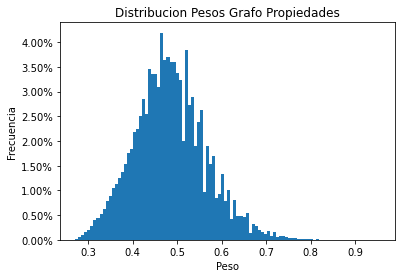

In [13]:
grafos.plot_histogram("props",bins=100)
plt.show()


Si quieres ver el efecto de varias potencias y filtros en la distribucion, usa filter_weights().

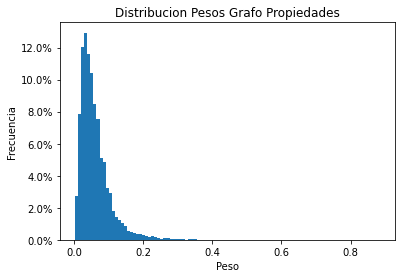

In [19]:
grafos.filter_weights("props",threshold=0.1,power=0.8)
grafos.plot_histogram("props",bins=100)
plt.show()

Para encontrar el treshold que mejor filtra los datos, utilizando la heuristica del codo, usa plot_filters. 

100%|██████████| 10/10 [24:29<00:00, 146.97s/it][0.0, 0.06328971119133574, 0.08592406618831981, 0.11880272243578778, 0.17103028754827732, 0.25858188463858406, 0.413515511762111, 0.6750365174608605, 0.948891309632057, 0.9999980306454082] [0.0, 0.9972853408405389, 0.9991956565453448, 0.9998994570681681, 0.9998994570681681, 1.0, 1.0, 1.0, 1.0, 1.0]



(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Filtrado Propiedades'}, xlabel='Vertices Relativos', ylabel='Cobertura'>,
 [<matplotlib.lines.Line2D at 0x13f291345c0>])

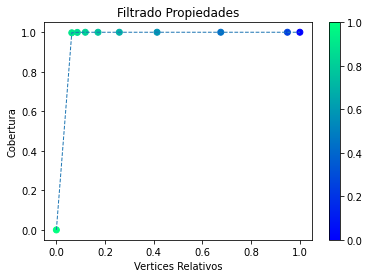

In [21]:
grafos.plot_filters("props")


Para encontrar la potencia que mejor separa los datos, es decir, que maximiza la desviacion estandar, usar plot_std().

100%|██████████| 11/11 [09:17<00:00, 50.65s/it]


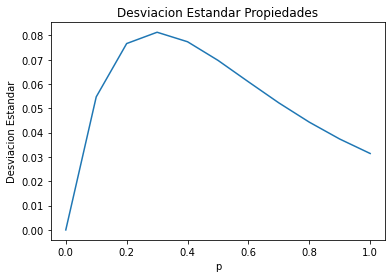

In [28]:
grafos.filter_weights("props",threshold=0.25)
grafos.plot_std("props")
plt.show()